In [120]:
import numpy as np
import pandas as pd
import random, re, string
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, f1_score
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import umap

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chandlerbeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chandlerbeon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/chandlerbeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/chandlerbeon/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/chandlerbeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chandlerbeon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load in dataset and train/test split
df = pd.read_csv('data/Project1-ClassificationDataset.csv')

train, test = train_test_split(df[["full_text", "root_label"]], test_size=0.2)

def convert_label_to_int(label):
    if label == 'climate':
        return 0
    else:
        return 1

train['root_label'] = train['root_label'].apply(convert_label_to_int)
test['root_label'] = test['root_label'].apply(convert_label_to_int)

In [7]:
# Load in GLoVE-300d embeddings
def load_glove_embeds(fp):
    embeddings_dict = {}
    dimension_of_glove = 300
    with open(fp, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

glove_300d_embeds = load_glove_embeds('data/glove.6B.300d.txt')

## Feature Engineering Using GLoVE Embeddings (300-dimensions)

Task: Binary classification of `root_label` (either 'sports' or 'climate')  

Constraints:
1. A representation of a text segment needs to have a vector dimension that CANNOT exceed the dimension of the GLoVE embedding used per word of the segment.
2. You cannot use TF-IDF scores (or any measure that requires looking at the complete dataset) as a pre-processing routine.
3. Important: In this section, feel free to use raw features from any column in the original data file not just full text. The column keywords might be useful... or not. Make sure that your result achieves an accuracy of at least 92%.
4. To aggregate these words into a single vector consider normalization the vectors, averaging across the vectors.


Part 1: Preprocessing
1. Convert all text to lowercase
2. Remove punctuation and stop words.
3. Lemmatize to reduce words to base words

In [104]:
stop_words = set(stopwords.words('english'))

# Given function to parse out HTML-related characters
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

def remove_stop_words(text):
    # Tokenize and remove stop words
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    return ' '.join(filtered_sentence)


# Define custom transformer to clean the dataset
class DocumentPreprocessingTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self

    def transform(self, X):
        # Strip all HTML-related artifacts
        X = X.apply(clean)

        # Remove all punctuation and digits
        ref_punct_digits = string.punctuation + string.digits
        X = X.apply(lambda x: x.translate(str.maketrans('', '', ref_punct_digits)))

        # Makes all characters lower-case
        # Note: Technically the CountVectorizer already handles it, but is necessary
        #       for lemmatization.
        X = X.apply(lambda x: x.lower())

        # Remove stop words
        X = X.apply(remove_stop_words)
        
        return X

# Define custom transfomer for lemmiatizatino
class LemmatizationPOSTransfomer(BaseEstimator, TransformerMixin):
    def lemmatize_documents(self, doc, wnl):
        """
        Lemmatizes documents (i.e. each entry) and returns the lemmatized
        document as a single string.
        """
        return [wnl.lemmatize(w[0], self.get_wordnet_pos(w[1])) for w in pos_tag(word_tokenize(doc))]


    # Nested function for getting part of speech
    def get_wordnet_pos(self, tag):
        """
        Maps POS tags to WordNet POS tags.

        Default to Noun.
        """
        if tag.startswith('J'):  # Adjective
            return wordnet.ADJ
        elif tag.startswith('V'):  # Verb
            return wordnet.VERB
        elif tag.startswith('N'):  # Noun
            return wordnet.NOUN
        elif tag.startswith('R'):  # Adverb
            return wordnet.ADV
        else:
            return wordnet.NOUN

    def fit(self, X):
        return self

    def transform(self, X):
        wnl = WordNetLemmatizer()
        X = X.apply(lambda x: self.lemmatize_documents(x, wnl))
        return X

# Define custom vectorizer for GLoVE embeddings
class GLoVEVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, embeddings, dims, normalize=False):
        self.embeddings = embeddings # Dictionary containing the word2vec embeddings
        self.dims = dims # Dimensions of the embeddings
        self.normalize = normalize # Flag variable for normalizing sentence vector output

    def embed_pooling(self, doc):
        word_vectors = []
        for word in doc:
                if word in self.embeddings:
                    word_vectors.append(self.embeddings[word])
                else:
                    word_vectors.append(np.zeros(self.dims)) # If word not in GLoVE vocabulary, just create vector of zeros.

        # Aggregate all word vectors by mean pooling
        sentence_vector = np.mean(np.array(word_vectors), axis=0)

        if self.normalize:
            sentence_vector = normalize_vector_l2(sentence_vector)

        return sentence_vector

    def fit(self, X):
        return self

    def transform(self, X):
        X = X.apply(self.embed_pooling)
            
        return np.stack(X.values)

def normalize_vector_l2(vector):
    """
    Normalizes the provided vector using L2 normalization.
    """
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector
    return vector / norm

In [105]:
pipe = Pipeline([
    # Step 1: Data Cleaning
    ('doc_preprocess', DocumentPreprocessingTransformer()),
    # Step 2: Lemmatization
    ('lemmatization', LemmatizationPOSTransfomer()),
    # Step 3: Tokenize and use GLoVE embedding
    ('embedding', GLoVEVectorizer(glove_300d_embeds, 300, normalize=True))
])

X_train = pipe.fit_transform(train['full_text'])
X_test = pipe.fit_transform(test['full_text'])
y_train = train['root_label']
y_test = test['root_label']

## Setting up XGBoost Binary Classification

In [106]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [111]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)


Accuracy: 0.9555
F1: 0.9574
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       328
           1       0.97      0.95      0.96       368

    accuracy                           0.96       696
   macro avg       0.96      0.96      0.96       696
weighted avg       0.96      0.96      0.96       696



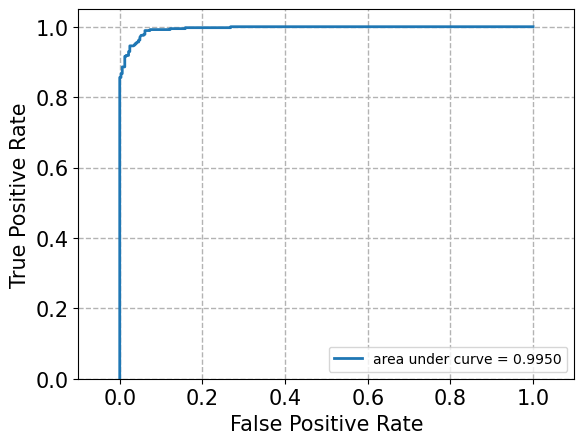

In [121]:
# Evaluate Classification Model
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1: {f1:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

prob_score = xgb_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, prob_score[:,1])
plot_roc(fpr, tpr)

## Comparison Between GLoVE Embedding Dimensionality and Model Accuracy.

In [97]:
# Load GLoVE embeddings 
glove_50d_embeds = load_glove_embeds('data/glove.6B.50d.txt')
glove_100d_embeds = load_glove_embeds('data/glove.6B.100d.txt')
glove_200d_embeds = load_glove_embeds('data/glove.6B.200d.txt')

glove_embeds = [
    (glove_50d_embeds, 50), 
    (glove_100d_embeds, 100), 
    (glove_200d_embeds, 200), 
    (glove_300d_embeds, 300)
]


In [99]:
# Create a 'checkpoint' of the dataset after lemmatization since these processes are repeated and they
# take a long time to run.

processing_pipe = Pipeline([
        # Step 1: Data Cleaning
        ('doc_preprocess', DocumentPreprocessingTransformer()),
        # Step 2: Lemmatization
        ('lemmatization', LemmatizationPOSTransfomer()),
    ])

post_lemm_train = processing_pipe.fit_transform(train['full_text'])
post_lemm_test = processing_pipe.fit_transform(test['full_text'])

In [100]:
# XGBoost Classifier 
xgb_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'eval_metric': 'logloss'
}

accuracy_scores_by_glove_dims = []
for glove_embed, dims in tqdm(glove_embeds):
    pipe = Pipeline([
        # Step 3: Tokenize and use GLoVE embedding
        ('embedding', GLoVEVectorizer(glove_embed, dims, normalize=True))
    ])

    # Generate features from GLoVE embeddings 
    X_train = pipe.fit_transform(post_lemm_train)
    y_train = train['root_label']
    X_test = pipe.fit_transform(post_lemm_test)
    y_test = test['root_label']

    # Instantiate and train model
    xgb_model = xgb.XGBClassifier(**xgb_params)
    xgb_model.fit(X_train, y_train)

    # Evaluate and save accuracy
    y_pred = xgb_model.predict(X_test)
    accuracy_scores_by_glove_dims += [(str(dims) + 'd', accuracy_score(y_test, y_pred))]

100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


In [101]:
accuracy_scores_by_glove_dims

[('50d', 0.9626436781609196),
 ('100d', 0.9698275862068966),
 ('200d', 0.9712643678160919),
 ('300d', 0.9554597701149425)]

Text(0.5, 1.0, 'GLoVE Embedding Vector Size vs Model Accuracy')

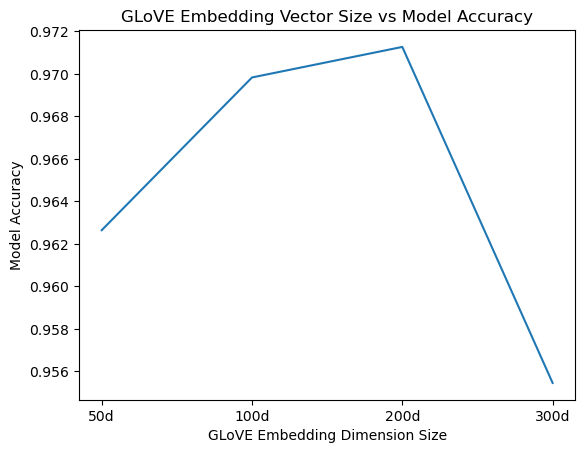

In [103]:
x_vals = [x[0] for x in accuracy_scores_by_glove_dims]
y_vals = [x[1] for x in accuracy_scores_by_glove_dims]

plt.plot(x_vals, y_vals)

plt.xlabel('GLoVE Embedding Dimension Size')
plt.ylabel('Model Accuracy')
plt.title('GLoVE Embedding Vector Size vs Model Accuracy')


## UMAP Visualization of GLoVE Embeddings

Visualize the set of normalized GLoVE-based embeddings of the documents with their binary labels in a 2D plane using the UMAP library. 

Similarly, generate a set of normalized random vectors of the same dimension as GLoVE and visualize these in a 2D plane with UMAP.

In [71]:
# ------------ UMAP Projections of GLoVE Sentence Embeddings ------------ #
# Since we're no longer evaluating models, we will be using the entire corpus instead of just the training set.
corpus = df['full_text']
labels = df['root_label']
corpus.shape

# Copying over the pipeline from Question 11 and cleaning the data... again... since we didn't save a checkpoint of the data after lemmatization...
pipe = Pipeline([
    # Step 1: Data Cleaning 
    ('doc_preprocess', DocumentPreprocessingTransformer()),
    # Step 2: Lemmatization
    ('lemmatization', LemmatizationPOSTransfomer()),
    # Step 3: Tokenize and use GLoVE embedding
    ('embedding', GLoVEVectorizer(glove_300d_embeds, 300, normalize=True)) 
])
corpus_processed = pipe.fit_transform(corpus)

umap_reducer = umap.UMAP()
glove_umap_embedding = reducer.fit_transform(corpus_processed)
glove_umap_embedding.shape


(3476, 2)

In [70]:
# ------------ UMAP Projections of Random Vectors ------------ #
labels = df['root_label']

# Note: The original sentence vectors have a dimension of 300 (since we're using the 300d GLoVE embeddings)
random_vectors = []
for _ in range(len(labels)):
    random_vectors.append(normalize_vector_l2(np.random.rand(300)))
random_vectors = np.array(random_vectors)

umap_reducer = umap.UMAP()
random_vec_embedding = reducer.fit_transform(random_vectors)
random_vec_embedding.shape

(3476, 2)

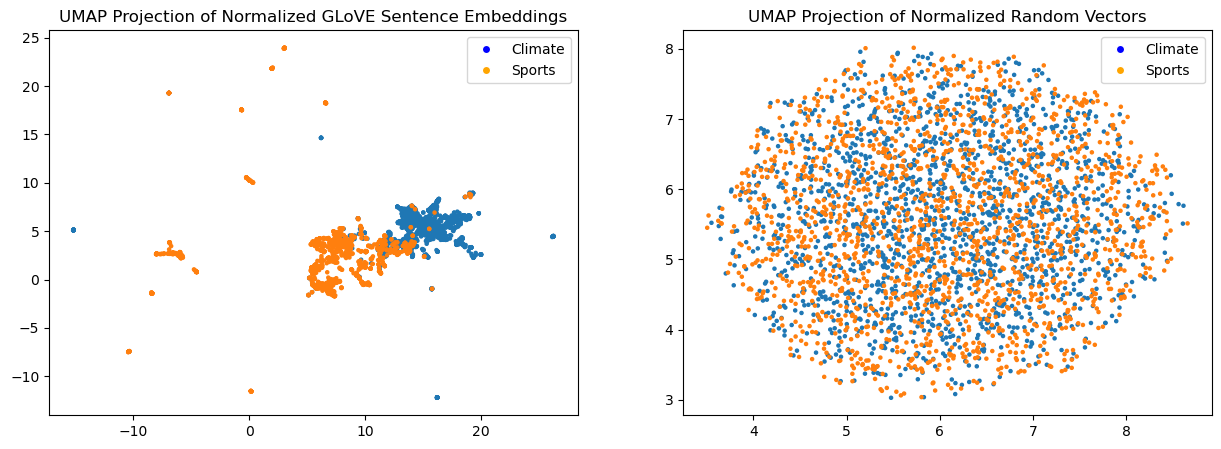

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Create custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Climate', markerfacecolor='blue'),
    Line2D([0], [0], marker='o', color='w', label='Sports', markerfacecolor='orange'),
]

# Plot UMAP Projection for GLoVE Embedding
ax1.scatter(
    glove_umap_embedding[:, 0], 
    glove_umap_embedding[:, 1], 
    c=[sns.color_palette()[x] for x in labels.map({'sports':0, 'climate':1})],
    s=5
)
ax1.set_title('UMAP Projection of Normalized GLoVE Sentence Embeddings', fontsize=12)
ax1.legend(handles=legend_elements)

# Plot UMAP Projection for Random Vectors
ax2.scatter(
    random_vec_embedding[:, 0], 
    random_vec_embedding[:, 1], 
    c=[sns.color_palette()[x] for x in labels.map({'sports':0, 'climate':1})],
    s=5
)
ax2.set_title('UMAP Projection of Normalized Random Vectors', fontsize=12)
ax2.legend(handles=legend_elements)

plt.show()